### Importing Libraries

In [43]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [44]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
# from tensorflow.keras.layers import ...
from keras import backend
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

### Importing Dataset

In [45]:
import pandas as pd
cols = ['degree_centrality', 'dist_to_dhoby', 'dist_to_nearest_stn', 'eigenvector_centrality', 'flat_model_type', 'floor_area_sqm', 'month', 'remaining_lease_years', 'storey_range',"year","resale_price"]
df = pd.read_csv('hdb_price_prediction.csv')
df = df.reindex(cols , axis=1)
# df = df.loc(,:)
# df = df.drop(["full_address","nearest_stn"],axis = 1)
df.head()

,degree_centrality,dist_to_dhoby,dist_to_nearest_stn,eigenvector_centrality,flat_model_type,floor_area_sqm,month,remaining_lease_years,storey_range,year,resale_price
0,0.016807,7.006044,1.007264,0.006243,"2 ROOM, Improved",44.0,1,61.333333,10 TO 12,2017,232000.0
1,0.016807,7.983837,1.271389,0.006243,"3 ROOM, New Generation",67.0,1,60.583333,01 TO 03,2017,250000.0
2,0.016807,9.090700,1.069743,0.002459,"3 ROOM, New Generation",67.0,1,62.416667,01 TO 03,2017,262000.0
3,0.016807,7.519889,0.946890,0.006243,"3 ROOM, New Generation",68.0,1,62.083333,04 TO 06,2017,265000.0
4,0.016807,9.130489,1.092551,0.002459,"3 ROOM, New Generation",67.0,1,62.416667,01 TO 03,2017,265000.0


### Defining functions for dataset preprocessing and feature creation

In [46]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    dataframe.pop("year")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    #ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
 
def r2(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

checkpoint_filepath = './checkpoint'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

### Dividing Dataset into Test and Train

In [47]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [48]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range_type = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_type_encoded = encode_categorical_feature(storey_range_type, "storey_range", train_ds, True)


# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)



all_features = layers.concatenate(
    [degree_centrality_encoded,
    dist_to_dhoby_encoded, 
    dist_to_nearest_stn_encoded, 
    eigenvector_centrality_encoded,
    flat_model_type_encoded,
    floor_area_sqm_encoded,
    month_encoded,
    remaining_lease_years_encoded,
    storey_range_type_encoded]
)

all_inputs = [degree_centrality,
              dist_to_dhoby, 
              dist_to_nearest_stn, 
              eigenvector_centrality,
              flat_model_type,
              floor_area_sqm,
              month,
              remaining_lease_years,
              storey_range_type]


### Creating Model Architecture

In [49]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model1 = keras.Model(all_inputs, output)
model1.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    metrics = [rmse,r2]
)
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
degree_centrality (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
dist_to_dhoby (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
dist_to_nearest_stn (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
eigenvector_centrality (InputLa [(None, 1)]          0                                            
____________________________________________________________________________________________

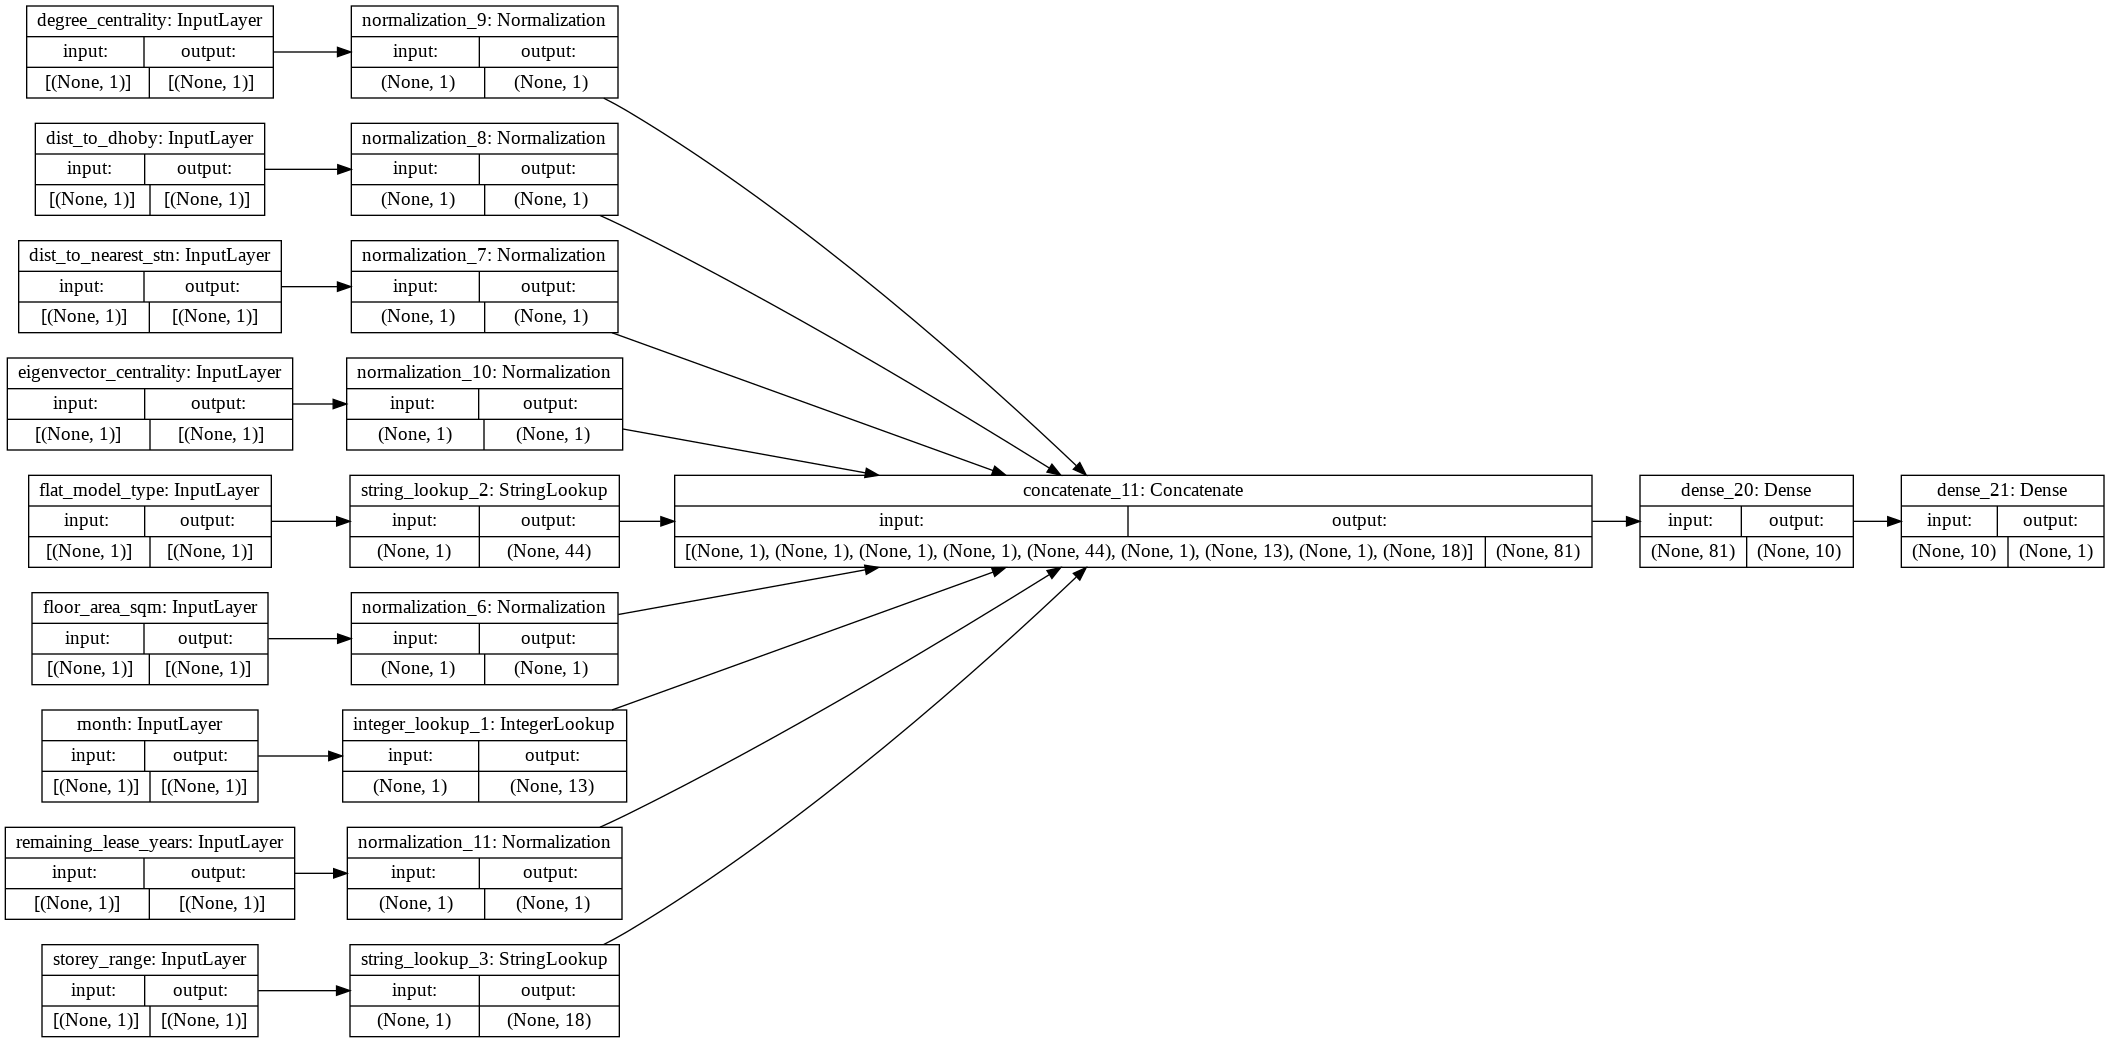

In [18]:
keras.utils.plot_model(model1, show_shapes=True, rankdir="LR")


### Training

In [50]:
history1 = model1.fit(train_ds, batch_size=128, epochs=100, validation_data=val_ds,callbacks=[callback])

Epoch 1/100
683/683 [==============================] - 2s 2ms/step - loss: 195353837568.0000 - rmse: 415787.5312 - r2: -11.5459 - val_loss: 196429152256.0000 - val_rmse: 418485.8750 - val_r2: -11.1055
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 92324298752.0000 - rmse: 273558.6250 - r2: -4.6977 - val_loss: 68696924160.0000 - val_rmse: 234653.5156 - val_r2: -2.9412
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 21535502336.0000 - rmse: 108745.5781 - r2: -0.1528 - val_loss: 18520313856.0000 - val_rmse: 99258.1484 - val_r2: 0.1080
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 7730658304.0000 - rmse: 60271.0273 - r2: 0.6088 - val_loss: 10550970368.0000 - val_rmse: 70504.6953 - val_r2: 0.5278
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 6084827136.0000 - rmse: 55584.7500 - r2: 0.6697 - val_loss: 8637433856.0000 - val_rmse: 64688.7578 - val_r2: 0.6144
Epoch 6/100
683/683 [===

683/683 [==============================] - 1s 2ms/step - loss: 3603362304.0000 - rmse: 45226.1797 - r2: 0.7856 - val_loss: 4866115584.0000 - val_rmse: 52159.0938 - val_r2: 0.7546
Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 3602441216.0000 - rmse: 45220.2148 - r2: 0.7856 - val_loss: 4863502848.0000 - val_rmse: 52145.8711 - val_r2: 0.7546
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 3601611008.0000 - rmse: 45214.6328 - r2: 0.7857 - val_loss: 4861104128.0000 - val_rmse: 52133.3086 - val_r2: 0.7547
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 3600861952.0000 - rmse: 45209.4531 - r2: 0.7857 - val_loss: 4858914304.0000 - val_rmse: 52121.3359 - val_r2: 0.7547
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 3600188928.0000 - rmse: 45204.6797 - r2: 0.7857 - val_loss: 4856916480.0000 - val_rmse: 52109.9336 - val_r2: 0.7548
Epoch 48/100
683/683 [==============================]

Epoch 86/100
683/683 [==============================] - 1s 2ms/step - loss: 3593386496.0000 - rmse: 45155.8008 - r2: 0.7857 - val_loss: 4834770432.0000 - val_rmse: 52003.2070 - val_r2: 0.7553
Epoch 87/100
683/683 [==============================] - 1s 2ms/step - loss: 3593341184.0000 - rmse: 45155.5977 - r2: 0.7857 - val_loss: 4834604032.0000 - val_rmse: 52002.6367 - val_r2: 0.7553
Epoch 88/100
683/683 [==============================] - 1s 2ms/step - loss: 3593294848.0000 - rmse: 45155.4062 - r2: 0.7857 - val_loss: 4834437632.0000 - val_rmse: 52002.0742 - val_r2: 0.7553
Epoch 89/100
683/683 [==============================] - 1s 2ms/step - loss: 3593249536.0000 - rmse: 45155.1953 - r2: 0.7857 - val_loss: 4834278400.0000 - val_rmse: 52001.5664 - val_r2: 0.7553
Epoch 90/100
683/683 [==============================] - 1s 2ms/step - loss: 3593204992.0000 - rmse: 45155.0234 - r2: 0.7857 - val_loss: 4834120192.0000 - val_rmse: 52001.0703 - val_r2: 0.7553
Epoch 91/100
683/683 [==================

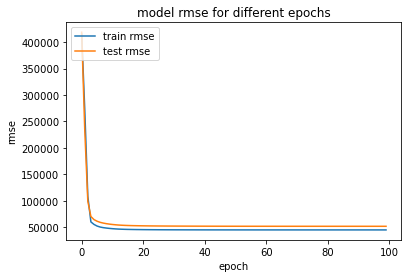

In [51]:
plt.plot(history1.history['rmse'])
plt.plot(history1.history['val_rmse'])

plt.title('model rmse for different epochs')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend( ["train rmse","test rmse"], loc='upper left')
plt.show()

In [52]:
model1.load_weights(checkpoint_filepath)

In [53]:
preds = model1.predict(val_ds)
print(preds.shape)
preds

(16723, 1)


array([[173990.64],
       [142922.4 ],
       [292464.53],
       ...,
       [410637.12],
       [416974.8 ],
       [483862.3 ]], dtype=float32)

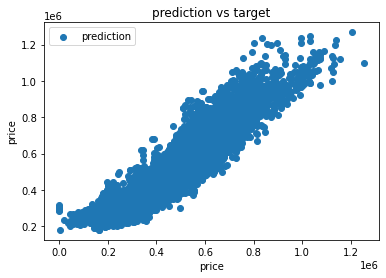

In [54]:
ls1 = []
for (x,y) in val_ds.as_numpy_iterator():
    ls1.extend(list(y))
plt.scatter(preds,ls1)
plt.title('prediction vs target')
plt.ylabel('price')
plt.xlabel('price')
plt.legend( ["prediction","target"], loc='upper left')
plt.show()

### Adding Embedding Layer to Categorical Features

In [55]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)
embed = tf.keras.layers.Embedding(13, 6,)(month_encoded)
month_encoded_embed = tf.keras.layers.Reshape(target_shape=(13*6,))(embed)

# # Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
embed = tf.keras.layers.Embedding(44, 22,)(flat_model_type_encoded)
flat_model_type_encoded_embed = tf.keras.layers.Reshape(target_shape=(44*22,))(embed)

storey_range_type = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_type_encoded = encode_categorical_feature(storey_range_type, "storey_range", train_ds, True)
embed = tf.keras.layers.Embedding(18, 9,)(storey_range_type_encoded)
storey_range_type_encoded_embed = tf.keras.layers.Reshape(target_shape=(18*9,))(embed)



# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)



all_features = layers.concatenate(
    [degree_centrality_encoded,
    dist_to_dhoby_encoded, 
    dist_to_nearest_stn_encoded, 
    eigenvector_centrality_encoded,
    flat_model_type_encoded_embed,
    floor_area_sqm_encoded,
    month_encoded_embed,
    remaining_lease_years_encoded,
    storey_range_type_encoded_embed]
)

all_inputs = [degree_centrality,
              dist_to_dhoby, 
              dist_to_nearest_stn, 
              eigenvector_centrality,
              flat_model_type,
              floor_area_sqm,
              month,
              remaining_lease_years,
              storey_range_type]


In [56]:
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    metrics = [rmse,r2]
)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup_10 (StringLookup) (None, 44)           0           flat_model_type[0][0]            
____________________________________________________________________________________________

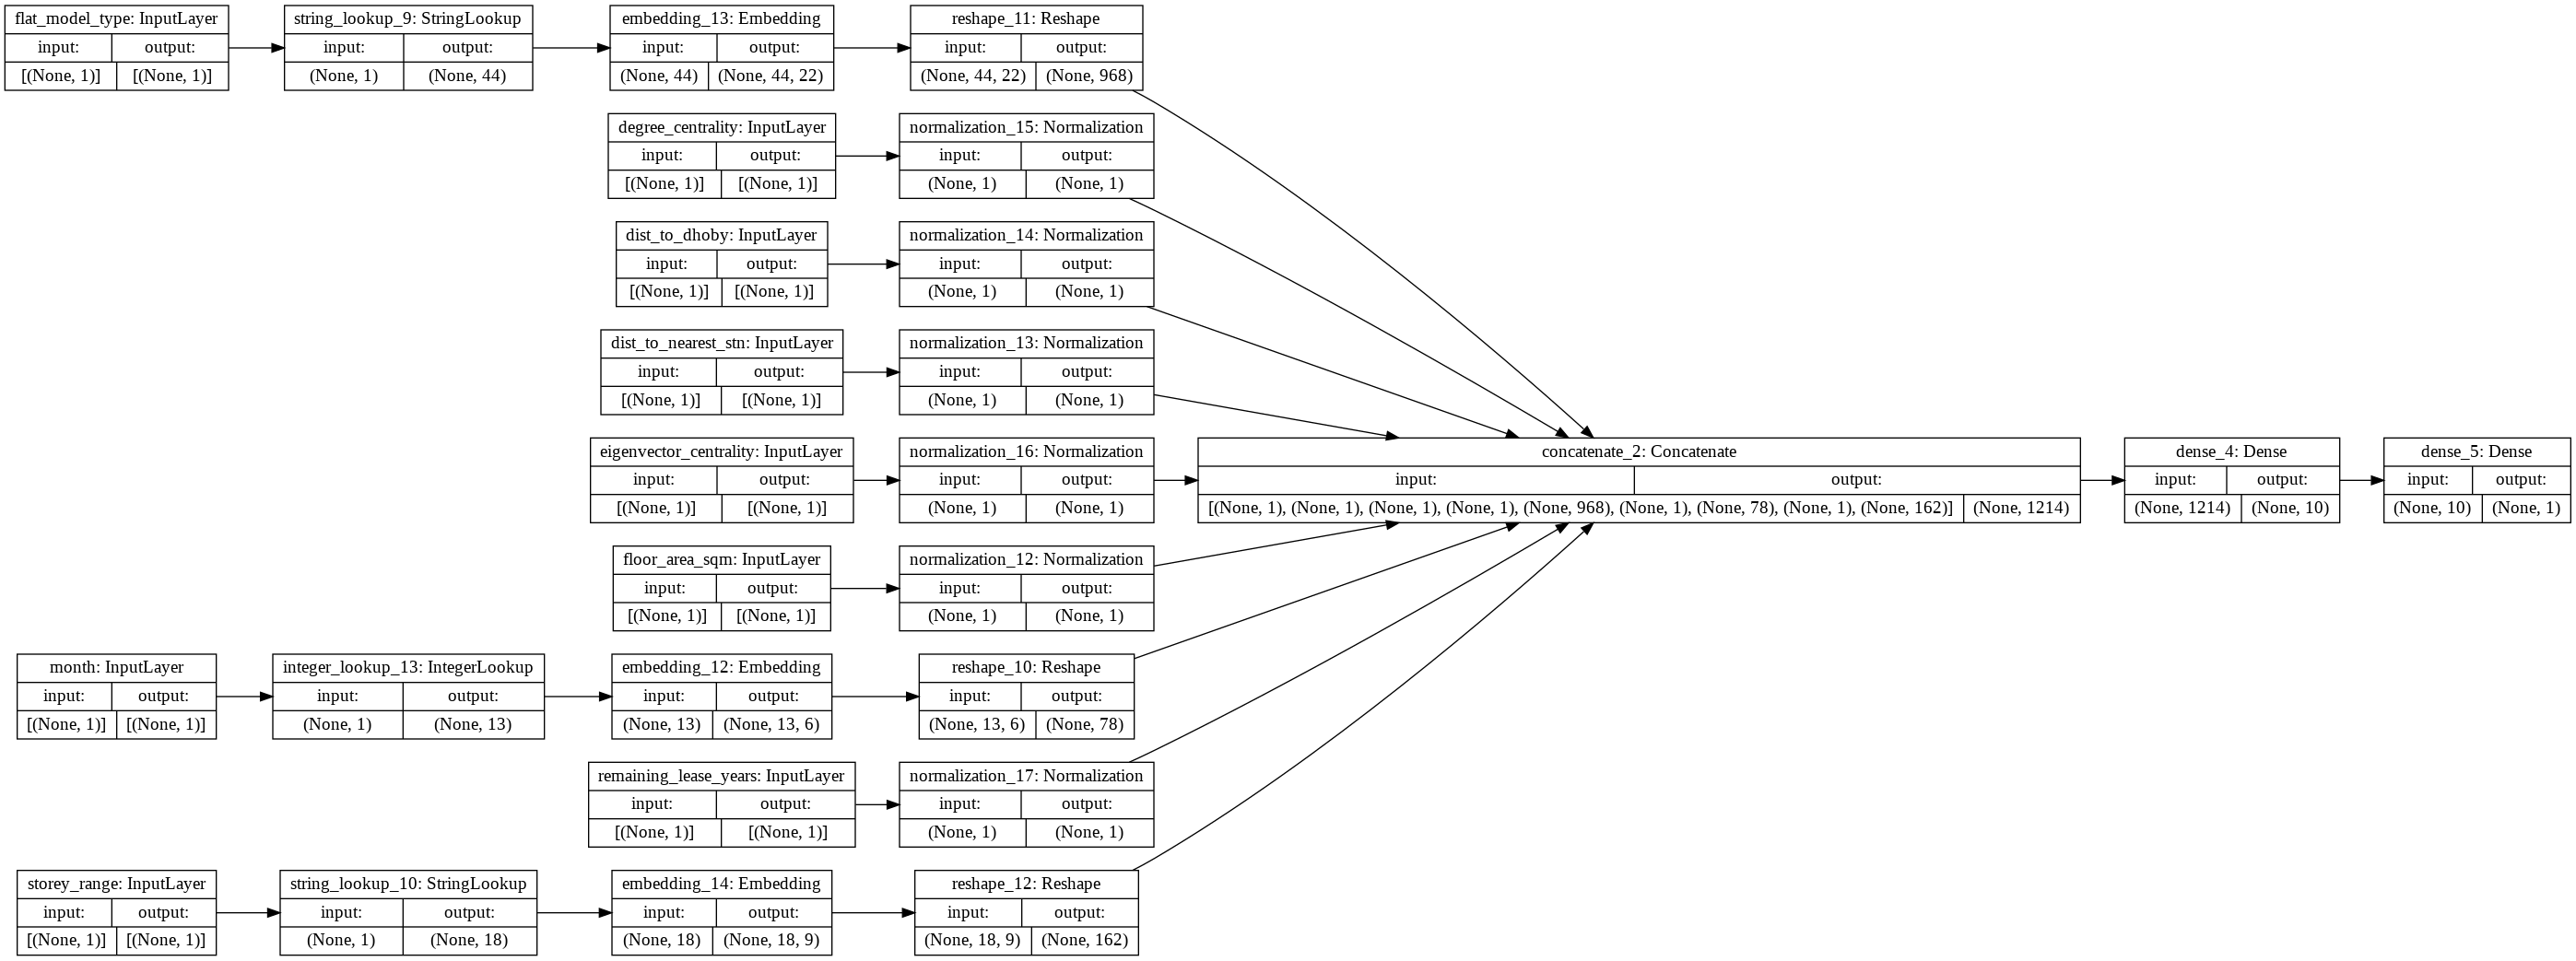

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [57]:
history = model.fit(train_ds, batch_size=128, epochs=100, validation_data=val_ds,callbacks=[callback])

Epoch 1/100
683/683 [==============================] - 2s 3ms/step - loss: 38727380992.0000 - rmse: 145401.3438 - r2: -1.1490 - val_loss: 25973014528.0000 - val_rmse: 123998.1172 - val_r2: -0.1061
Epoch 2/100
683/683 [==============================] - 2s 2ms/step - loss: 22459275264.0000 - rmse: 114983.0781 - r2: -0.0954 - val_loss: 20595679232.0000 - val_rmse: 106574.6328 - val_r2: 0.1393
Epoch 3/100
683/683 [==============================] - 2s 2ms/step - loss: 14096476160.0000 - rmse: 86515.2188 - r2: 0.2812 - val_loss: 13185426432.0000 - val_rmse: 76788.5312 - val_r2: 0.4698
Epoch 4/100
683/683 [==============================] - 2s 2ms/step - loss: 11014114304.0000 - rmse: 75618.7266 - r2: 0.4240 - val_loss: 11158702080.0000 - val_rmse: 69887.5625 - val_r2: 0.5451
Epoch 5/100
683/683 [==============================] - 2s 3ms/step - loss: 9429506048.0000 - rmse: 70218.2188 - r2: 0.4921 - val_loss: 9876449280.0000 - val_rmse: 66967.9922 - val_r2: 0.5722
Epoch 6/100
683/683 [=========

Epoch 44/100
683/683 [==============================] - 2s 2ms/step - loss: 3047349504.0000 - rmse: 40039.8828 - r2: 0.8104 - val_loss: 4113894144.0000 - val_rmse: 47022.9141 - val_r2: 0.7787
Epoch 45/100
683/683 [==============================] - 2s 2ms/step - loss: 3033758976.0000 - rmse: 39974.7656 - r2: 0.8108 - val_loss: 4188795904.0000 - val_rmse: 47522.6055 - val_r2: 0.7743
Epoch 46/100
683/683 [==============================] - 2s 2ms/step - loss: 3023626752.0000 - rmse: 39913.5625 - r2: 0.8110 - val_loss: 4319836160.0000 - val_rmse: 48426.8203 - val_r2: 0.7664
Epoch 47/100
683/683 [==============================] - 2s 2ms/step - loss: 3014864896.0000 - rmse: 39783.9297 - r2: 0.8113 - val_loss: 4460516864.0000 - val_rmse: 49277.2656 - val_r2: 0.7581
Epoch 48/100
683/683 [==============================] - 2s 2ms/step - loss: 3017113088.0000 - rmse: 39831.3438 - r2: 0.8110 - val_loss: 4579353088.0000 - val_rmse: 50102.4648 - val_r2: 0.7513
Epoch 49/100
683/683 [==================

Epoch 87/100
683/683 [==============================] - 2s 2ms/step - loss: 2692105472.0000 - rmse: 37760.1094 - r2: 0.8337 - val_loss: 3574101760.0000 - val_rmse: 44109.5000 - val_r2: 0.8057
Epoch 88/100
683/683 [==============================] - 2s 3ms/step - loss: 2690094592.0000 - rmse: 37747.3633 - r2: 0.8339 - val_loss: 3561576704.0000 - val_rmse: 44029.8789 - val_r2: 0.8064
Epoch 89/100
683/683 [==============================] - 2s 2ms/step - loss: 2688033024.0000 - rmse: 37735.9102 - r2: 0.8341 - val_loss: 3542470912.0000 - val_rmse: 43905.5078 - val_r2: 0.8074
Epoch 90/100
683/683 [==============================] - 2s 3ms/step - loss: 2685259264.0000 - rmse: 37719.3789 - r2: 0.8344 - val_loss: 3524805376.0000 - val_rmse: 43763.9727 - val_r2: 0.8086
Epoch 91/100
683/683 [==============================] - 2s 2ms/step - loss: 2682384128.0000 - rmse: 37700.1719 - r2: 0.8347 - val_loss: 3517586944.0000 - val_rmse: 43713.8359 - val_r2: 0.8090
Epoch 92/100
683/683 [==================

### Recursive Feature Elimination

In [58]:
encoded = [degree_centrality_encoded,
    dist_to_dhoby_encoded, 
    dist_to_nearest_stn_encoded, 
    eigenvector_centrality_encoded,
    flat_model_type_encoded_embed,
    floor_area_sqm_encoded,
    month_encoded_embed,
    remaining_lease_years_encoded,
    storey_range_type_encoded_embed]
inp_layers = [degree_centrality,
              dist_to_dhoby, 
              dist_to_nearest_stn, 
              eigenvector_centrality,
              flat_model_type,
              floor_area_sqm,
              month,
              remaining_lease_years,
              storey_range_type]

hist_list = []
s = [0,1,2,3,4,5,6,7,8,9]
for x in range(0,len(encoded)+1):
    indices = [y for ind,y in enumerate(s) if x != ind]
    # print(indices)
    enc = [y for ind,y in enumerate(encoded) if x != ind]
    inp = [y for ind,y in enumerate(inp_layers) if x != ind]
    # print(inp)
    # break

    x = layers.Dense(10, activation="relu")(layers.concatenate(enc))
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, output)
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(learning_rate=0.05),
        metrics = [rmse,r2]
    )
    hist_list.append(model.fit(train_ds, batch_size=128, epochs=100, validation_data=val_ds,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]))
    

Epoch 1/100


C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['degree_centrality'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 29954056192.0000 - rmse: 121869.2891 - r2: -0.6538 - val_loss: 13838497792.0000 - val_rmse: 78419.2500 - val_r2: 0.4447
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 10823568384.0000 - rmse: 75526.3516 - r2: 0.4258 - val_loss: 10821874688.0000 - val_rmse: 69691.0234 - val_r2: 0.5353
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 9264556032.0000 - rmse: 70005.7734 - r2: 0.4873 - val_loss: 9864572928.0000 - val_rmse: 67147.2734 - val_r2: 0.5595
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 8601221120.0000 - rmse: 67422.6719 - r2: 0.5179 - val_loss: 9260319744.0000 - val_rmse: 65145.0508 - val_r2: 0.5807
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 8126632960.0000 - rmse: 65429.5273 - r2: 0.5431 - val_loss: 8797382656.0000 - val_rmse: 63455.5195 - val_r2: 0.5996
Epoch 6/100
683/683 [==============================

Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 3062862080.0000 - rmse: 40456.9102 - r2: 0.8134 - val_loss: 3808633856.0000 - val_rmse: 44990.3398 - val_r2: 0.7996
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 3053685504.0000 - rmse: 40405.6758 - r2: 0.8139 - val_loss: 3805067008.0000 - val_rmse: 44994.1719 - val_r2: 0.7996
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 3045345792.0000 - rmse: 40357.0469 - r2: 0.8143 - val_loss: 3793966336.0000 - val_rmse: 44943.9375 - val_r2: 0.8001
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 3037259008.0000 - rmse: 40307.5703 - r2: 0.8149 - val_loss: 3787855104.0000 - val_rmse: 44902.2617 - val_r2: 0.8005
Epoch 48/100
683/683 [==============================] - 1s 2ms/step - loss: 3029527808.0000 - rmse: 40258.2461 - r2: 0.8153 - val_loss: 3789414400.0000 - val_rmse: 44925.4492 - val_r2: 0.8002
Epoch 49/100
683/683 [==================

Epoch 87/100
683/683 [==============================] - 2s 2ms/step - loss: 2822842368.0000 - rmse: 38706.7891 - r2: 0.8302 - val_loss: 3622900480.0000 - val_rmse: 43968.5977 - val_r2: 0.8076
Epoch 88/100
683/683 [==============================] - 1s 2ms/step - loss: 2819577600.0000 - rmse: 38683.5273 - r2: 0.8305 - val_loss: 3616323840.0000 - val_rmse: 43932.3789 - val_r2: 0.8078
Epoch 89/100
683/683 [==============================] - 1s 2ms/step - loss: 2816602880.0000 - rmse: 38658.9141 - r2: 0.8307 - val_loss: 3608094464.0000 - val_rmse: 43861.9922 - val_r2: 0.8083
Epoch 90/100
683/683 [==============================] - 1s 2ms/step - loss: 2813398784.0000 - rmse: 38634.3867 - r2: 0.8309 - val_loss: 3598773248.0000 - val_rmse: 43787.8555 - val_r2: 0.8089
Epoch 91/100
683/683 [==============================] - 1s 2ms/step - loss: 2810684672.0000 - rmse: 38613.5664 - r2: 0.8312 - val_loss: 3600072192.0000 - val_rmse: 43800.0898 - val_r2: 0.8088
Epoch 92/100
683/683 [==================

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 28417327104.0000 - rmse: 117830.8359 - r2: -0.5615 - val_loss: 13158522880.0000 - val_rmse: 76050.3281 - val_r2: 0.4656
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 10454965248.0000 - rmse: 74251.1875 - r2: 0.4343 - val_loss: 10773196800.0000 - val_rmse: 69399.8984 - val_r2: 0.5317
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 9279293440.0000 - rmse: 69924.6406 - r2: 0.4827 - val_loss: 10050447360.0000 - val_rmse: 67443.0312 - val_r2: 0.5535
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 8774799360.0000 - rmse: 67940.1406 - r2: 0.5073 - val_loss: 9576275968.0000 - val_rmse: 65925.1562 - val_r2: 0.5714
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 8407881728.0000 - rmse: 66409.5859 - r2: 0.5269 - val_loss: 9220636672.0000 - val_rmse: 64727.3633 - val_r2: 0.5865
Epoch 6/100
683/683 [=============================

Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 6327396864.0000 - rmse: 57219.7852 - r2: 0.6483 - val_loss: 6860896768.0000 - val_rmse: 56742.7617 - val_r2: 0.6930
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 6290631680.0000 - rmse: 57044.7891 - r2: 0.6504 - val_loss: 6815144448.0000 - val_rmse: 56556.2812 - val_r2: 0.6948
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 6248980480.0000 - rmse: 56840.4023 - r2: 0.6528 - val_loss: 6784549376.0000 - val_rmse: 56402.5000 - val_r2: 0.6965
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 6203655168.0000 - rmse: 56609.8750 - r2: 0.6554 - val_loss: 6710507520.0000 - val_rmse: 56050.6680 - val_r2: 0.6997
Epoch 48/100
683/683 [==============================] - 1s 2ms/step - loss: 6161651712.0000 - rmse: 56379.6328 - r2: 0.6579 - val_loss: 6663129600.0000 - val_rmse: 55829.5273 - val_r2: 0.7019
Epoch 49/100
683/683 [==================

Epoch 87/100
683/683 [==============================] - 1s 2ms/step - loss: 5618979840.0000 - rmse: 52883.5430 - r2: 0.6963 - val_loss: 5962326016.0000 - val_rmse: 52008.5547 - val_r2: 0.7374
Epoch 88/100
683/683 [==============================] - 1s 2ms/step - loss: 5613796352.0000 - rmse: 52856.6875 - r2: 0.6966 - val_loss: 5960866816.0000 - val_rmse: 51983.1836 - val_r2: 0.7378
Epoch 89/100
683/683 [==============================] - 1s 2ms/step - loss: 5610598400.0000 - rmse: 52841.3633 - r2: 0.6968 - val_loss: 5976123392.0000 - val_rmse: 52029.1562 - val_r2: 0.7375
Epoch 90/100
683/683 [==============================] - 1s 2ms/step - loss: 5608503808.0000 - rmse: 52836.2070 - r2: 0.6970 - val_loss: 5963604992.0000 - val_rmse: 51996.2227 - val_r2: 0.7377
Epoch 91/100
683/683 [==============================] - 1s 2ms/step - loss: 5606745600.0000 - rmse: 52829.2266 - r2: 0.6971 - val_loss: 5951429120.0000 - val_rmse: 51945.8594 - val_r2: 0.7381
Epoch 92/100
683/683 [==================

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 28738738176.0000 - rmse: 118648.4297 - r2: -0.5826 - val_loss: 13157304320.0000 - val_rmse: 76242.4766 - val_r2: 0.4620
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 10425379840.0000 - rmse: 74214.8359 - r2: 0.4331 - val_loss: 10710001664.0000 - val_rmse: 69305.2734 - val_r2: 0.5293
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 9204162560.0000 - rmse: 69754.1875 - r2: 0.4816 - val_loss: 9949285376.0000 - val_rmse: 67202.5547 - val_r2: 0.5503
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 8651224064.0000 - rmse: 67622.3828 - r2: 0.5065 - val_loss: 9438589952.0000 - val_rmse: 65576.4297 - val_r2: 0.5675
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 8228030976.0000 - rmse: 65905.5234 - r2: 0.5270 - val_loss: 9037441024.0000 - val_rmse: 64209.1094 - val_r2: 0.5821
Epoch 6/100
683/683 [==============================

Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 4386070016.0000 - rmse: 50651.5391 - r2: 0.7104 - val_loss: 5499512320.0000 - val_rmse: 55968.6445 - val_r2: 0.7049
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 4381694464.0000 - rmse: 50637.8203 - r2: 0.7105 - val_loss: 5476525056.0000 - val_rmse: 55850.5547 - val_r2: 0.7059
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 4377405952.0000 - rmse: 50625.3906 - r2: 0.7106 - val_loss: 5468839936.0000 - val_rmse: 55819.2812 - val_r2: 0.7063
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 4372038144.0000 - rmse: 50604.8633 - r2: 0.7111 - val_loss: 5348612096.0000 - val_rmse: 55143.2266 - val_r2: 0.7118
Epoch 48/100
683/683 [==============================] - 1s 2ms/step - loss: 4371406336.0000 - rmse: 50610.7109 - r2: 0.7107 - val_loss: 5563087872.0000 - val_rmse: 56368.8164 - val_r2: 0.7019
Epoch 49/100
683/683 [==================

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 29917741056.0000 - rmse: 121640.4922 - r2: -0.6542 - val_loss: 13546739712.0000 - val_rmse: 77845.0156 - val_r2: 0.4448
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 10596686848.0000 - rmse: 74781.4688 - r2: 0.4287 - val_loss: 10751003648.0000 - val_rmse: 69443.3828 - val_r2: 0.5302
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 9255760896.0000 - rmse: 69806.3516 - r2: 0.4848 - val_loss: 9930946560.0000 - val_rmse: 67101.0234 - val_r2: 0.5558
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 8670871552.0000 - rmse: 67541.5156 - r2: 0.5135 - val_loss: 9391400960.0000 - val_rmse: 65359.1055 - val_r2: 0.5764
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 8225609216.0000 - rmse: 65692.0156 - r2: 0.5373 - val_loss: 8953472000.0000 - val_rmse: 63798.0000 - val_r2: 0.5946
Epoch 6/100
683/683 [==============================

Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 2833341184.0000 - rmse: 38545.6562 - r2: 0.8257 - val_loss: 3573465344.0000 - val_rmse: 43614.4883 - val_r2: 0.8079
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 2825412096.0000 - rmse: 38493.8711 - r2: 0.8261 - val_loss: 3588162048.0000 - val_rmse: 43731.0977 - val_r2: 0.8071
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 2817992448.0000 - rmse: 38450.4219 - r2: 0.8267 - val_loss: 3597272064.0000 - val_rmse: 43788.7734 - val_r2: 0.8068
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 2809853952.0000 - rmse: 38399.1953 - r2: 0.8274 - val_loss: 3598395392.0000 - val_rmse: 43766.7500 - val_r2: 0.8068
Epoch 48/100
683/683 [==============================] - 1s 2ms/step - loss: 2801643520.0000 - rmse: 38347.3516 - r2: 0.8281 - val_loss: 3589433088.0000 - val_rmse: 43684.7969 - val_r2: 0.8074
Epoch 49/100
683/683 [==================

Epoch 87/100
683/683 [==============================] - 1s 2ms/step - loss: 2611205888.0000 - rmse: 36984.8711 - r2: 0.8433 - val_loss: 3454281216.0000 - val_rmse: 42915.4648 - val_r2: 0.8155
Epoch 88/100
683/683 [==============================] - 1s 2ms/step - loss: 2608500224.0000 - rmse: 36967.7891 - r2: 0.8435 - val_loss: 3454105088.0000 - val_rmse: 42903.6602 - val_r2: 0.8155
Epoch 89/100
683/683 [==============================] - 1s 2ms/step - loss: 2605553152.0000 - rmse: 36946.5078 - r2: 0.8438 - val_loss: 3452570624.0000 - val_rmse: 42881.9727 - val_r2: 0.8156
Epoch 90/100
683/683 [==============================] - 1s 2ms/step - loss: 2602508544.0000 - rmse: 36924.5898 - r2: 0.8440 - val_loss: 3453062400.0000 - val_rmse: 42878.0117 - val_r2: 0.8156
Epoch 91/100
683/683 [==============================] - 1s 2ms/step - loss: 2600201472.0000 - rmse: 36908.0859 - r2: 0.8442 - val_loss: 3449953280.0000 - val_rmse: 42865.0000 - val_r2: 0.8158
Epoch 92/100
683/683 [==================

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['flat_model_type'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 40968531968.0000 - rmse: 148780.2969 - r2: -1.3317 - val_loss: 24579110912.0000 - val_rmse: 119926.9219 - val_r2: -0.0537
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 21147721728.0000 - rmse: 112317.8125 - r2: -0.0583 - val_loss: 22704857088.0000 - val_rmse: 116162.5938 - val_r2: -0.0268
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 19725520896.0000 - rmse: 108684.7031 - r2: -0.0185 - val_loss: 21375531008.0000 - val_rmse: 112931.6719 - val_r2: 0.0032
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 18616158208.0000 - rmse: 105450.4219 - r2: 0.0241 - val_loss: 20188882944.0000 - val_rmse: 109630.0312 - val_r2: 0.0470
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 17501577216.0000 - rmse: 102024.4141 - r2: 0.0779 - val_loss: 18920220672.0000 - val_rmse: 105814.6875 - val_r2: 0.1043
Epoch 6/100
683/683 [===========

683/683 [==============================] - 1s 2ms/step - loss: 3467759872.0000 - rmse: 43249.4102 - r2: 0.7883 - val_loss: 4386314752.0000 - val_rmse: 47929.2109 - val_r2: 0.7718
Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 3426708224.0000 - rmse: 42880.3281 - r2: 0.7911 - val_loss: 4262227456.0000 - val_rmse: 47134.7031 - val_r2: 0.7776
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 3393911040.0000 - rmse: 42574.0625 - r2: 0.7932 - val_loss: 4216158720.0000 - val_rmse: 46774.4805 - val_r2: 0.7797
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 3365993216.0000 - rmse: 42305.5586 - r2: 0.7950 - val_loss: 4199451136.0000 - val_rmse: 46614.3906 - val_r2: 0.7802
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 3343088128.0000 - rmse: 42075.5586 - r2: 0.7965 - val_loss: 4177756160.0000 - val_rmse: 46424.2578 - val_r2: 0.7810
Epoch 48/100
683/683 [==============================]

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 30620590080.0000 - rmse: 124068.2656 - r2: -0.6860 - val_loss: 14013403136.0000 - val_rmse: 79651.8594 - val_r2: 0.4263
Epoch 2/100
683/683 [==============================] - 2s 2ms/step - loss: 10692602880.0000 - rmse: 75188.6953 - r2: 0.4262 - val_loss: 10680089600.0000 - val_rmse: 69295.2578 - val_r2: 0.5341
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 9133162496.0000 - rmse: 69394.1484 - r2: 0.4912 - val_loss: 9753271296.0000 - val_rmse: 66613.7734 - val_r2: 0.5626
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 8468578304.0000 - rmse: 66761.2266 - r2: 0.5230 - val_loss: 9134539776.0000 - val_rmse: 64549.0859 - val_r2: 0.5855
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 7961226752.0000 - rmse: 64612.7930 - r2: 0.5497 - val_loss: 8641799168.0000 - val_rmse: 62800.1523 - val_r2: 0.6056
Epoch 6/100
683/683 [==============================

Epoch 44/100
683/683 [==============================] - 2s 2ms/step - loss: 3092313088.0000 - rmse: 40225.9258 - r2: 0.8053 - val_loss: 3856141312.0000 - val_rmse: 45228.3867 - val_r2: 0.7912
Epoch 45/100
683/683 [==============================] - 2s 2ms/step - loss: 3084613376.0000 - rmse: 40183.9883 - r2: 0.8057 - val_loss: 3841243904.0000 - val_rmse: 45125.7812 - val_r2: 0.7920
Epoch 46/100
683/683 [==============================] - 2s 2ms/step - loss: 3078175744.0000 - rmse: 40149.8516 - r2: 0.8061 - val_loss: 3816257792.0000 - val_rmse: 44874.8086 - val_r2: 0.7935
Epoch 47/100
683/683 [==============================] - 2s 2ms/step - loss: 3071293184.0000 - rmse: 40107.1562 - r2: 0.8064 - val_loss: 3802515456.0000 - val_rmse: 44752.8828 - val_r2: 0.7941
Epoch 48/100
683/683 [==============================] - 1s 2ms/step - loss: 3065037056.0000 - rmse: 40069.2695 - r2: 0.8068 - val_loss: 3780805632.0000 - val_rmse: 44569.8398 - val_r2: 0.7952
Epoch 49/100
683/683 [==================

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['month'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 31042390016.0000 - rmse: 123844.3906 - r2: -0.7276 - val_loss: 13870602240.0000 - val_rmse: 79068.3203 - val_r2: 0.4351
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 10793144320.0000 - rmse: 75379.7422 - r2: 0.4226 - val_loss: 10840407040.0000 - val_rmse: 69728.8516 - val_r2: 0.5291
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 9316499456.0000 - rmse: 70051.2422 - r2: 0.4828 - val_loss: 9924372480.0000 - val_rmse: 67155.2188 - val_r2: 0.5553
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 8679051264.0000 - rmse: 67587.2109 - r2: 0.5127 - val_loss: 9346736128.0000 - val_rmse: 65336.0742 - val_r2: 0.5760
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 8208879104.0000 - rmse: 65646.8984 - r2: 0.5370 - val_loss: 8872128512.0000 - val_rmse: 63660.4375 - val_r2: 0.5949
Epoch 6/100
683/683 [==============================

683/683 [==============================] - 1s 2ms/step - loss: 2920089856.0000 - rmse: 39144.4023 - r2: 0.8185 - val_loss: 3518778112.0000 - val_rmse: 43496.1914 - val_r2: 0.8099
Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 2903073024.0000 - rmse: 39051.3828 - r2: 0.8196 - val_loss: 3489911040.0000 - val_rmse: 43241.8164 - val_r2: 0.8119
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 2887691264.0000 - rmse: 38967.4102 - r2: 0.8206 - val_loss: 3478992640.0000 - val_rmse: 43194.8555 - val_r2: 0.8124
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 2872925184.0000 - rmse: 38888.0234 - r2: 0.8215 - val_loss: 3463453440.0000 - val_rmse: 43089.6992 - val_r2: 0.8133
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 2859519488.0000 - rmse: 38814.5156 - r2: 0.8223 - val_loss: 3448008960.0000 - val_rmse: 42990.1016 - val_r2: 0.8141
Epoch 48/100
683/683 [==============================]

Epoch 86/100
683/683 [==============================] - 1s 2ms/step - loss: 2656297216.0000 - rmse: 37485.9922 - r2: 0.8367 - val_loss: 3154980608.0000 - val_rmse: 41033.8672 - val_r2: 0.8299
Epoch 87/100
683/683 [==============================] - 1s 2ms/step - loss: 2656698880.0000 - rmse: 37484.0508 - r2: 0.8367 - val_loss: 3193635072.0000 - val_rmse: 41277.9609 - val_r2: 0.8277
Epoch 88/100
683/683 [==============================] - 2s 2ms/step - loss: 2652039168.0000 - rmse: 37443.0820 - r2: 0.8372 - val_loss: 3154357248.0000 - val_rmse: 41045.2070 - val_r2: 0.8298
Epoch 89/100
683/683 [==============================] - 1s 2ms/step - loss: 2649690112.0000 - rmse: 37412.0664 - r2: 0.8375 - val_loss: 3176914432.0000 - val_rmse: 41184.0000 - val_r2: 0.8287
Epoch 90/100
683/683 [==============================] - 2s 2ms/step - loss: 2644737536.0000 - rmse: 37359.5664 - r2: 0.8379 - val_loss: 3148995840.0000 - val_rmse: 40986.4375 - val_r2: 0.8302
Epoch 91/100
683/683 [==================

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 28120782848.0000 - rmse: 117013.2500 - r2: -0.5458 - val_loss: 12722021376.0000 - val_rmse: 75018.9844 - val_r2: 0.4784
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 10031868928.0000 - rmse: 72776.8906 - r2: 0.4536 - val_loss: 10283624448.0000 - val_rmse: 68067.9219 - val_r2: 0.5472
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 8775878656.0000 - rmse: 68011.3672 - r2: 0.5079 - val_loss: 9426530304.0000 - val_rmse: 65527.9922 - val_r2: 0.5751
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 8124803584.0000 - rmse: 65327.9141 - r2: 0.5412 - val_loss: 8826682368.0000 - val_rmse: 63518.3711 - val_r2: 0.5978
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 7598669824.0000 - rmse: 63063.3867 - r2: 0.5704 - val_loss: 8363671040.0000 - val_rmse: 61960.6328 - val_r2: 0.6164
Epoch 6/100
683/683 [==============================

Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 3362270720.0000 - rmse: 42804.9062 - r2: 0.7978 - val_loss: 4132795392.0000 - val_rmse: 46996.9297 - val_r2: 0.7671
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 3357094144.0000 - rmse: 42777.1406 - r2: 0.7981 - val_loss: 4132487680.0000 - val_rmse: 46989.4531 - val_r2: 0.7671
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 3352649216.0000 - rmse: 42756.7109 - r2: 0.7983 - val_loss: 4125049088.0000 - val_rmse: 46951.9648 - val_r2: 0.7674
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 3351066880.0000 - rmse: 42747.4961 - r2: 0.7985 - val_loss: 4122889728.0000 - val_rmse: 46931.8945 - val_r2: 0.7676
Epoch 48/100
683/683 [==============================] - 1s 2ms/step - loss: 3348089600.0000 - rmse: 42729.1992 - r2: 0.7986 - val_loss: 4126201344.0000 - val_rmse: 46983.4883 - val_r2: 0.7670
Epoch 49/100
683/683 [==================

C:\Users\USER\anaconda3\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['storey_range'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 2s 2ms/step - loss: 42029715456.0000 - rmse: 148610.6094 - r2: -1.4504 - val_loss: 20511240192.0000 - val_rmse: 105624.6719 - val_r2: 0.1509
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 15282719744.0000 - rmse: 91070.2578 - r2: 0.2373 - val_loss: 14657472512.0000 - val_rmse: 82090.3750 - val_r2: 0.4052
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 12514933760.0000 - rmse: 80929.8047 - r2: 0.3522 - val_loss: 13076910080.0000 - val_rmse: 76656.2344 - val_r2: 0.4675
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 11585144832.0000 - rmse: 77671.3828 - r2: 0.3940 - val_loss: 12384510976.0000 - val_rmse: 74510.8594 - val_r2: 0.4913
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 11070563328.0000 - rmse: 75817.3984 - r2: 0.4165 - val_loss: 11991262208.0000 - val_rmse: 73567.1250 - val_r2: 0.5038
Epoch 6/100
683/683 [=======================

Epoch 44/100
683/683 [==============================] - 1s 2ms/step - loss: 5077573120.0000 - rmse: 51844.4570 - r2: 0.7075 - val_loss: 6151244288.0000 - val_rmse: 56321.0547 - val_r2: 0.7092
Epoch 45/100
683/683 [==============================] - 1s 2ms/step - loss: 5046008832.0000 - rmse: 51722.8398 - r2: 0.7089 - val_loss: 6119916544.0000 - val_rmse: 56246.5977 - val_r2: 0.7104
Epoch 46/100
683/683 [==============================] - 1s 2ms/step - loss: 5016105984.0000 - rmse: 51610.8906 - r2: 0.7102 - val_loss: 6090046464.0000 - val_rmse: 56178.2188 - val_r2: 0.7115
Epoch 47/100
683/683 [==============================] - 1s 2ms/step - loss: 4987758592.0000 - rmse: 51508.3281 - r2: 0.7113 - val_loss: 6061732352.0000 - val_rmse: 56114.5312 - val_r2: 0.7126
Epoch 48/100
683/683 [==============================] - 1s 2ms/step - loss: 4960875008.0000 - rmse: 51414.0430 - r2: 0.7124 - val_loss: 6035179520.0000 - val_rmse: 56057.8633 - val_r2: 0.7135
Epoch 49/100
683/683 [==================

Epoch 87/100
683/683 [==============================] - 2s 2ms/step - loss: 4473284096.0000 - rmse: 50120.3281 - r2: 0.7279 - val_loss: 5562889216.0000 - val_rmse: 55135.8516 - val_r2: 0.7285
Epoch 88/100
683/683 [==============================] - 1s 2ms/step - loss: 4468206592.0000 - rmse: 50104.1562 - r2: 0.7281 - val_loss: 5546355200.0000 - val_rmse: 55057.5039 - val_r2: 0.7291
Epoch 89/100
683/683 [==============================] - 1s 2ms/step - loss: 4463198208.0000 - rmse: 50087.5820 - r2: 0.7283 - val_loss: 5530523136.0000 - val_rmse: 54983.9219 - val_r2: 0.7297
Epoch 90/100
683/683 [==============================] - 1s 2ms/step - loss: 4458548736.0000 - rmse: 50072.0547 - r2: 0.7285 - val_loss: 5515303936.0000 - val_rmse: 54910.0625 - val_r2: 0.7303
Epoch 91/100
683/683 [==============================] - 1s 2ms/step - loss: 4453945856.0000 - rmse: 50056.8008 - r2: 0.7287 - val_loss: 5502253056.0000 - val_rmse: 54849.8477 - val_r2: 0.7308
Epoch 92/100
683/683 [==================

Epoch 30/100
683/683 [==============================] - 1s 2ms/step - loss: 3165987328.0000 - rmse: 40481.2266 - r2: 0.8055 - val_loss: 4125271808.0000 - val_rmse: 46775.4844 - val_r2: 0.7783
Epoch 31/100
683/683 [==============================] - 1s 2ms/step - loss: 3131505408.0000 - rmse: 40289.0586 - r2: 0.8072 - val_loss: 4092326656.0000 - val_rmse: 46628.9453 - val_r2: 0.7798
Epoch 32/100
683/683 [==============================] - 1s 2ms/step - loss: 3100842496.0000 - rmse: 40116.3711 - r2: 0.8087 - val_loss: 4077460736.0000 - val_rmse: 46608.5273 - val_r2: 0.7803
Epoch 33/100
683/683 [==============================] - 1s 2ms/step - loss: 3072409600.0000 - rmse: 39959.8281 - r2: 0.8102 - val_loss: 4036864000.0000 - val_rmse: 46359.9414 - val_r2: 0.7825
Epoch 34/100
683/683 [==============================] - 1s 2ms/step - loss: 3046424320.0000 - rmse: 39821.8359 - r2: 0.8114 - val_loss: 4001576960.0000 - val_rmse: 46192.8281 - val_r2: 0.7843
Epoch 35/100
683/683 [==================

Epoch 73/100
683/683 [==============================] - 2s 2ms/step - loss: 2660199168.0000 - rmse: 37584.4297 - r2: 0.8370 - val_loss: 3452723200.0000 - val_rmse: 42959.8320 - val_r2: 0.8154
Epoch 74/100
683/683 [==============================] - 2s 2ms/step - loss: 2656078592.0000 - rmse: 37556.1367 - r2: 0.8374 - val_loss: 3451775232.0000 - val_rmse: 42955.4375 - val_r2: 0.8155
Epoch 75/100
683/683 [==============================] - 2s 2ms/step - loss: 2651935488.0000 - rmse: 37528.9297 - r2: 0.8377 - val_loss: 3453019904.0000 - val_rmse: 42984.6484 - val_r2: 0.8155
Epoch 76/100
683/683 [==============================] - 2s 2ms/step - loss: 2648828160.0000 - rmse: 37510.0977 - r2: 0.8380 - val_loss: 3446146048.0000 - val_rmse: 42920.5078 - val_r2: 0.8160
Epoch 77/100
683/683 [==============================] - 1s 2ms/step - loss: 2645470976.0000 - rmse: 37487.3984 - r2: 0.8383 - val_loss: 3438628096.0000 - val_rmse: 42853.7617 - val_r2: 0.8165
Epoch 78/100
683/683 [==================

In [59]:
rmsevals = []
features = ["degree_centrality",
              "dist_to_dhoby", 
              "dist_to_nearest_stn", 
              "eigenvector_centrality",
              "flat_model_type",
              "floor_area_sqm",
              "month",
              "remaining_lease_years",
              "storey_range_type"]
for x in hist_list:
    rmsevals.append(sorted( x.history["val_rmse"] , key = lambda x:float(x) )[0])


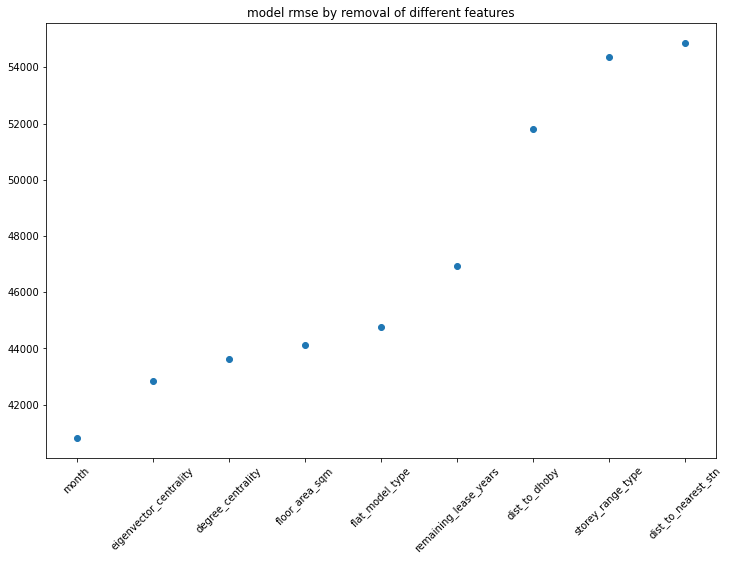

In [60]:
plt.figure(figsize=(12, 8))
plt.scatter([x for _, x in sorted(zip(rmsevals, features))],sorted( rmsevals[:-1] , key = lambda x:float(x) ))
plt.title('model rmse by removal of different features')

plt.xticks(rotation=45)
plt.show()